In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from nlp_dauphine.preprocess_data import (
        load_data, 
        text_cleaning, 
        link_texts_series, 
        suppr_footnotes, 
        categorical_other
        )
from nlp_dauphine.embeddings import vocabulary
from nlp_dauphine.utils import set_working_dir
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from category_encoders import WOEEncoder

In [3]:
set_working_dir()

Current working dir: /Users/thomasflourent/Documents/Master Data Science/Challenge_NLP/Challenge_NLP_Natixis/notebooks
New working dir: /Users/thomasflourent/Documents/Master Data Science/Challenge_NLP/Challenge_NLP_Natixis


# Load Data

In [4]:
path = Path("data")
files_path = {
    "ecb": Path(path,"ecb_data.csv"),
    "fed": Path(path,"fed_data.csv"),
    "train_series": Path(path,"train_series.csv"),
}

In [5]:
# LOAD TEXT DATA
df_ecb, df_fed, df_train_series = load_data(files_path)
print(df_ecb.shape, df_fed.shape, df_train_series.shape)

(1772, 3) (739, 3) (8946, 14)


# Text Cleaning

## Link Texts to Series

Create some indices

In [ ]:
df_ecb.reset_index(inplace=True, names="id_ecb")
df_fed.reset_index(inplace=True, names="id_fed")
df_train_series.reset_index(inplace=True, names="id_series")

Create a list rather than a string with a comma separator

In [ ]:
df_train_series["id_ecb"] = [x.split(",") for x in df_train_series['index ecb']]
df_train_series["id_fed"] = [x.split(",") for x in df_train_series['index fed']]
del df_train_series['index ecb']
del df_train_series['index fed']

## Remove Footnotes

In [ ]:
df_ecb["text_process"] = df_ecb.text.apply(lambda x: suppr_footnotes(x))
df_fed["text_process"] = df_fed.text.apply(lambda x: suppr_footnotes(x))

## Deal with Null Values

In [ ]:
# REPLACE NULL TEXTS BY TITLE
index_no_texts = df_ecb[df_ecb["text_process"].isnull()].index.values
df_ecb.loc[index_no_texts, "text_process"] = df_ecb.loc[index_no_texts, "title"].values

## Remove special characters, stop words, Lemmatization...

In [ ]:
# Clean Data
negation_words = ["no", "not"]
df_fed.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    ) for x in df_fed.text_process]
df_ecb.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    ) for x in df_ecb.text_process]

Less efficient 

In [ ]:
"""# CLEAN TEXTS
negation_words = ["no", "not"]
df_fed.text_process = df_fed.text_process.apply(
    lambda x: text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    )
)
df_ecb.text_process = df_ecb.text_process.apply(
    lambda x: text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    )
)"""

In [ ]:
#df_fed.text_process = a 
#df_ecb.text_process = b

Length of the texts

In [ ]:
lenght_texts_ecb = [len(str(x).split(" ")) for x in df_ecb.text]
lenght_texts_fed = [len(str(x).split(" ")) for x in df_fed.text]
fig, ax = plt.subplots(1,2)
ax[0].hist(lenght_texts_ecb, bins=50)
ax[0].set_title("ECB")
ax[1].hist(lenght_texts_fed, bins=50)
ax[1].set_title("FED")
plt.show()

In [ ]:
lenght_texts_ecb = [len(str(x).split(" ")) for x in df_ecb.text_process]
lenght_texts_fed = [len(str(x).split(" ")) for x in df_fed.text_process]
fig, ax = plt.subplots(1,2)
ax[0].hist(lenght_texts_ecb, bins=50)
ax[0].set_title("ECB")
ax[1].hist(lenght_texts_fed, bins=50)
ax[1].set_title("FED")
plt.show()

In [ ]:
#np.where(np.array(lenght_texts_ecb).astype('int64')<200)

# Categorical Variable: Speakers

In [ ]:
df_fed.speaker.value_counts()

In [ ]:
df_ecb.speaker = categorical_other(df_ecb.speaker)
df_fed.speaker = categorical_other(df_fed.speaker, threshold=0.025)

# Text Concatenation

In [ ]:
df_train_series.head()

In [ ]:
df_series_ecb_process = link_texts_series(df_train_series, df_ecb, "id_series", "id_ecb")
df_series_fed_process = link_texts_series(df_train_series, df_fed, "id_series", "id_fed")

In [ ]:
df_train_series = df_train_series.merge(df_series_ecb_process,on='id_series',how='left')
df_train_series = df_train_series.merge(df_series_fed_process,on='id_series',how='left')
df_train_series.head()

In [ ]:
df_train_series.shape

In [ ]:
df_train_series.loc[df_train_series['Index + 1']==0.0]

# Removal Zero value Time series

Probably due to a score approximation 

Some times all indices are null

In [ ]:
df_train_series.loc[df_train_series['Index + 1']==0.0]['Index Name'].value_counts()

In [ ]:
sup = df_train_series.loc[df_train_series['Index + 1']==0.0].index
df_train_series.drop(sup,inplace=True)

In [ ]:
df_train_series.to_csv("./data/train_series_clean_no_0.csv")

In [ ]:
df_train_series.id_fed.apply(lambda x: len(x))#.argmax()

# Train Test Split

In [ ]:
# Train test split 
X=df_train_series.loc[:,df_train_series.columns!="Index + 1"]
y=df_train_series[["Index + 1"]]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)
print(X_train.shape,y_train.shape)

Binary Classification

In [ ]:
y_t = np.sign(y_train)
y_t.value_counts()

In [ ]:
from pandas.plotting import lag_plot
lag_plot(series)
pyplot.show()

# Categorical Encoding 

In [ ]:
col_speakers = ["speaker_"+str(i+1) for i in range(4)]
test_conc = pd.concat([X_train, X_train['list_speakers_ecb'].apply(pd.Series)], axis=1)
test_conc.rename({i:col for i, col in enumerate(col_speakers)},axis=1,inplace=True)
enc = WOEEncoder(cols=col_speakers)
tr = enc.fit_transform(test_conc, y_t)
tr.fillna(0,inplace=True)

In [ ]:
tr.head()

# Transformers

## Research

In [6]:
df_train_series = pd.read_csv("./data/train_series_clean_no_0.csv")

In [7]:
df_train_series

,Unnamed: 0,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index + 1,id_ecb,id_fed,text_concat_ecb,list_speakers_ecb,text_concat_fed,list_speakers_fed
0,0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,0.054050,0.015779,0.010597,"['1126', '1471']",['96'],welcome address welcome remark philip r lane m...,"['Philip R. Lane', 'Luis de Guindos']",delighted helsinki important conference moneta...,['Vice Chairman Richard H. Clarida']
1,1,1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,0.007422,0.000000,0.014492,['975'],['568'],monetary policy structural reform euro area sp...,['Mario Draghi'],watch live would like thank federal reserve ba...,['Vice Chairman Stanley Fischer']
2,2,2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,0.005040,0.000156,0.016263,"['78', '806']","['328', '695']",challenge opportunity reboot european financia...,"['Benoît Cœuré', 'Benoît Cœuré']",grateful national association business economi...,"['Vice Chairman Stanley Fischer', 'Governor La..."
3,3,3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,0.001018,-0.002582,0.013581,"['560', '1405']",['118'],create stability uncertain world speech peter ...,"['Peter Praet', 'Peter Praet']",thank invitation speak today begin take stock ...,['Governor Jerome H. Powell']
4,4,4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,-0.000729,-0.000365,0.005092,['404'],['261'],money private currency reflection libra speech...,['Yves Mersch'],year symposium topic challenge monetary policy...,['Chairman Jerome H. Powell']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8235,8941,8941,SPX Index,-0.002045,-0.003642,0.008096,0.004949,-0.001264,0.000150,0.002482,0.000000,-0.000786,-0.002723,-0.003198,['294'],['195'],bank union future bank speech vítor constâncio...,['Vítor Constâncio'],illustrate quite literally chart new york fed ...,['Governor Daniel K. Tarullo']
8236,8942,8942,SX5E Index,-0.027361,0.094386,0.002350,-0.005076,0.022555,0.000963,-0.060170,0.028323,0.006516,-0.000338,-0.050491,['277'],"['199', '372']",restart market case interbank market speech lo...,['Lorenzo Bini Smaghi'],financial system turmoil past month credit con...,"['Chairman Ben S. Bernanke', 'Governor Randall..."
8237,8943,8943,SX5E Index,-0.008359,0.021658,-0.015986,-0.023528,0.020072,0.017822,0.005648,0.017045,0.008557,-0.003072,0.008092,"['78', '806']","['99', '625']",challenge opportunity reboot european financia...,"['Benoît Cœuré', 'Benoît Cœuré']",paper review federal open market committee fom...,"['Governor Jerome H. Powell', 'Governor Lael B..."
8238,8944,8944,SRVIX Index,0.011945,0.002567,0.000000,0.005115,0.000364,0.003999,0.012978,0.012458,-0.006032,0.005088,-0.003784,"['1660', '20']",['79'],speech occasion annual danish top executive su...,"['Peter Praet', 'Vítor Constâncio']",thank claudia thanks american economic associa...,['Vice Chair Janet L. Yellen']


In [8]:
from functools import partial
import torch
import torch.nn as nn
from transformers import AutoModel, AutoConfig
from typing import Dict, List

/Users/thomasflourent/miniforge3/envs/nlp_dauphine/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def hidden_state_embedding(hidden_states: torch.Tensor, layers: List[int],
                           use_cls: bool, reduce_mean: bool = True) -> torch.Tensor:
    """
    Extract embeddings from hidden attention state layers.

    Parameters
    ----------
    hidden_states
        Attention hidden states in the transformer model.
    layers
        List of layers to use for the embedding.
    use_cls
        Whether to use the next sentence token (CLS) to extract the embeddings.
    reduce_mean
        Whether to take the mean of the output tensor.

    Returns
    -------
    Tensor with embeddings.
    """
    hs = [hidden_states[layer][:, 0:1, :] if use_cls else hidden_states[layer] for layer in layers]
    hs = torch.cat(hs, dim=1)  # type: ignore
    y = hs.mean(dim=1) if reduce_mean else hs  # type: ignore
    return y

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, AutoModel, AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline


# config_tone = AutoConfig.from_pretrained('yiyanghkust/finbert-tone', output_hidden_states=True)
# finbert_model_tone = AutoModel.from_pretrained('yiyanghkust/finbert-tone')

# config_pretrain = AutoConfig.from_pretrained('yiyanghkust/finbert-pretrain', output_hidden_states=True)
# finbert_model_pretrain = AutoModel.from_pretrained('yiyanghkust/finbert-pretrain')

# sentiment_tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
# auto_tokenizer_pretrain = AutoTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

# sentiment_model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')


In [11]:
mps_device = torch.device("mps")

In [ ]:

emb_type = 'hidden_state'
n_layers = 8
layers = [-_ for _ in range(1, n_layers + 1)]
max_len = 512
tokens = auto_tokenizer_pretrain(list(df_train_series['text_concat_ecb'][:5]), pad_to_max_length=True,
                   max_length=max_len, return_tensors='pt')

hs_emb = partial(hidden_state_embedding, layers=layers, use_cls=emb_type.endswith('cls'))

output = finbert_model_pretrain(**tokens)
attention_hidden_states = output.hidden_states[1:]

embedding = hs_emb(attention_hidden_states)



In [ ]:
output.last_hidden_state.shape

In [ ]:

x_emb = embedding(tokens)
print(x_emb.shape)




In [12]:
def get_text_tokens_split(tokens, max_length):
    columns = list(tokens.keys())
    n = tokens[columns[0]].shape[1]
    n_split = n//max_length
    list_tokens = []
    if n > max_length:
        for k in range(n_split):
            tokens_trunc = dict()
            for column in columns :
                tokens_trunc[column] = tokens[column][:, k*max_length:(k+1)*max_length]
            list_tokens.append(tokens_trunc)
        tokens_trunc = dict()
        for column in columns :
                tokens_trunc[column] = tokens[column][:, max_length*(n_split)::]
        list_tokens.append(tokens_trunc)
    else:
         list_tokens.append(tokens)
    return list_tokens

In [13]:
def get_predictions(text, tokenizer, model):
    text_tokenized = tokenizer.encode_plus(text, return_tensors='pt').to(mps_device)
    inputs = get_text_tokens_split(text_tokenized, max_length=512)
    n = len(inputs)
    pred_splits = np.zeros((n,3))
    
    for k, input in enumerate(inputs) :
        try:
            output = model(**input)
            prediction = torch.nn.functional.softmax(output.logits, dim=-1).to(mps_device)
            prediction_copy = prediction.cpu()
            pred_splits[k] = prediction_copy.detach().numpy()
        except:
            pred_splits[k] = np.full((1,3), np.nan)
    return np.nanmean(pred_splits, axis=0), np.nanstd(pred_splits, axis=0)

In [14]:
#get_predictions(df_train_series['text_concat_fed'][109], sentiment_tokenizer, sentiment_model)

In [15]:
from tqdm import tqdm
from joblib import Parallel, delayed

def get_predictions_all(df, tokenizer, model, column):
    n = df.shape[0]
    predictions_mean = np.zeros((n,3))
    predictions_std = np.zeros((n,3))
    for k in tqdm(range(n)):
        text = df[column][k]
        try :
            predictions_mean[k], predictions_std[k]  = get_predictions(text, tokenizer, model)
        except:
            predictions_mean[k], predictions_std[k] = np.array([0.33, 0.33, 0.33]), np.array([0.0, 0.0, 0.0])
    new_df = df.copy()
    new_df['positive_sent_mean_'+column] = predictions_mean[:,0]
    new_df['negative_sent_mean_'+column] = predictions_mean[:,1]
    new_df['neutral_sent_mean_'+column] = predictions_mean[:,2]
    new_df['positive_sent_std_'+column] = predictions_std[:,0]
    new_df['negative_sent_std_'+column] = predictions_std[:,1]
    new_df['neutral_sent_std_'+column] = predictions_std[:,2]
    return new_df

In [16]:
def parallel_get_predictions_all(df, column):

    n = df.shape[0]
    predictions = np.zeros((n,3))
    texts = df[column]
    def get_prediction(text):
        return get_predictions(text, sentiment_tokenizer, sentiment_model)

    predictions_list = Parallel(n_jobs=-1)(delayed(get_prediction)(texts[k]) for k in tqdm(range(n)))
    
    for k, prediction in enumerate(predictions_list):
        predictions[k] = prediction
    
    new_df = df.copy()
    new_df['positive_sent_'+column] = predictions[:,0]
    new_df['negative_sent_'+column] = predictions[:,1]
    new_df['neutral_sent_'+column] = predictions[:,2]

    return new_df

In [17]:
# sentiment_tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# sentiment_model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')
# sentiment_model.to(mps_device)

sentiment_tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')

sentiment_model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')
sentiment_model.to(mps_device)



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [18]:
df_train_series['target'] = df_train_series['Index + 1'].apply(lambda x: 1 if x>0 else 0)

In [20]:
df_sent_ecb = pd.read_csv('./data/df_sent_preds__mean_std.csv')

In [22]:
df_sent_pred_ecb_PAI = get_predictions_all(df_train_series, sentiment_tokenizer, sentiment_model, column='text_concat_ecb')

100%|██████████| 8240/8240 [44:41<00:00,  3.07it/s]  


In [23]:
df_sent_pred_ecb_PAI_tot = get_predictions_all(df_sent_pred_ecb_PAI, sentiment_tokenizer, sentiment_model, column='text_concat_fed')

100%|██████████| 8240/8240 [2:16:39<00:00,  1.00it/s]     


In [24]:
df_sent_pred_ecb_PAI_tot.to_csv('./data/df_sent_pred_tot_PAI.csv')

In [25]:
df_sent_tot = pd.read_csv('./data/df_sent_pred_tot_PAI.csv')

In [26]:
df_sent_tot.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id_series', 'Index Name', 'Index - 9',
       'Index - 8', 'Index - 7', 'Index - 6', 'Index - 5', 'Index - 4',
       'Index - 3', 'Index - 2', 'Index - 1', 'Index - 0', 'Index + 1',
       'id_ecb', 'id_fed', 'text_concat_ecb', 'list_speakers_ecb',
       'text_concat_fed', 'list_speakers_fed', 'target',
       'positive_sent_mean_text_concat_ecb',
       'negative_sent_mean_text_concat_ecb',
       'neutral_sent_mean_text_concat_ecb',
       'positive_sent_std_text_concat_ecb',
       'negative_sent_std_text_concat_ecb', 'neutral_sent_std_text_concat_ecb',
       'positive_sent_mean_text_concat_fed',
       'negative_sent_mean_text_concat_fed',
       'neutral_sent_mean_text_concat_fed',
       'positive_sent_std_text_concat_fed',
       'negative_sent_std_text_concat_fed',
       'neutral_sent_std_text_concat_fed'],
      dtype='object')

In [27]:
import seaborn as sns

In [28]:
corr = df_sent_tot.loc[:,['Index + 1','positive_sent_mean_text_concat_ecb', 'negative_sent_mean_text_concat_ecb', 'neutral_sent_mean_text_concat_ecb',
                   'positive_sent_std_text_concat_ecb', 'negative_sent_std_text_concat_ecb', 'neutral_sent_std_text_concat_ecb',
                   'positive_sent_mean_text_concat_fed', 'negative_sent_mean_text_concat_fed', 'neutral_sent_mean_text_concat_fed',
                   'positive_sent_std_text_concat_fed', 'negative_sent_std_text_concat_fed', 'neutral_sent_std_text_concat_fed']].corr()

<Axes: >

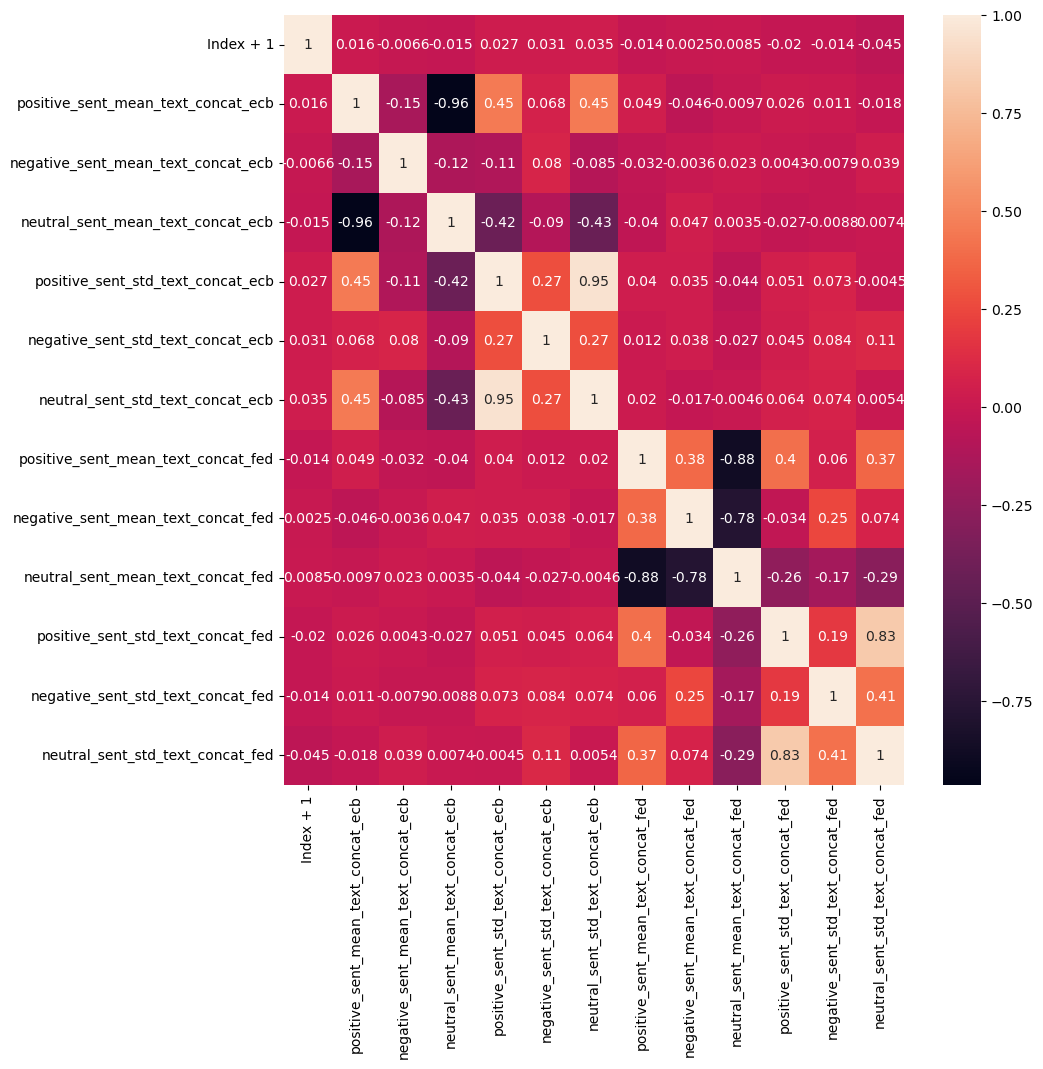

In [29]:
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)